<a href="https://colab.research.google.com/github/PurvaNatoo/ML_FacialEmotionRecognitionAndMusisRecommendation/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries

In [ ]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data fetching, cleaning and visualization

Fetching data

In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/Emotion Recognition/Images/fer2013/fer2013.csv")
df2 = pd.read_csv("/content/drive/MyDrive/Emotion Recognition/icml_face_data.csv")
df1.columns = ['emotion', 'pixels', 'usage']
df2.columns = ['emotion', 'usage', 'pixels']
df2.insert(1, 'pixels', df2.pop('pixels'))
data = pd.concat([df1, df2], axis=0)
print(data.head(5))

   emotion                                             pixels     usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


In [ ]:
data['usage'].value_counts()

Training       45889
PublicTest      3589
PrivateTest     3589
Name: usage, dtype: int64

In [ ]:
data = data.drop('usage', axis=1)
data.head(5)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
data.shape

(53068, 2)

In [ ]:
from PIL import Image
dataset = []

In [ ]:
for i in range(len(data)): #column 2 has the pixels. Row 1 is column name.
    #print(image_pixels)
    label = int(data.iloc[i, -2])
    image_pixels = data.iloc[i, -1]
    try:
      image_data = np.fromstring(image_pixels, dtype=int, sep=' ').reshape(48,48,1)
      dataset.append([image_data, label])
    except:
      print("Problem with string")

Problem with string


In [ ]:
len(dataset)

53067

Displaying images

In [ ]:
import random
random.seed(42)

In [ ]:
emotion_dict = {0:'angry', 1:'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}

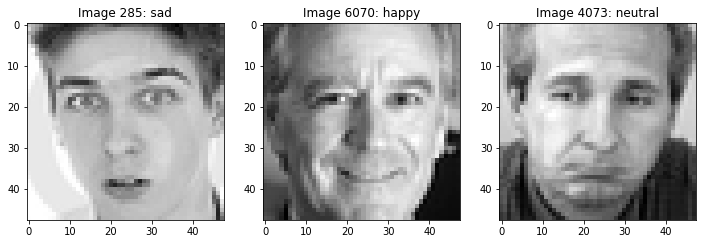

In [ ]:
random.shuffle(dataset)
fig = plt.figure(figsize=(12, 12))
for i in range(3):
  num = random.randint(0, 53066)
  a = fig.add_subplot(1, 3, i+1)
  img = dataset[num][0]
  image_plot = plt.imshow(img.reshape(48, 48), cmap="binary_r")
  emotion_num = dataset[num][1]
  emotion = emotion_dict[emotion_num]
  a.set_title("Image " + str(num) + ": " + emotion)

### Train Test split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support

In [ ]:
x = np.array([sample[0] for sample in dataset])
y = np.array([sample[1] for sample in dataset])

In [ ]:
x.shape

(53067, 48, 48, 1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42, shuffle = True)

In [ ]:
print("Number of samples in each class:")
train_sample = pd.DataFrame({'Type': y_train})
train_sample.value_counts()

Number of samples in each class:


Type
3       11935
6        8260
4        8106
2        6867
0        6609
5        5253
1         730
dtype: int64

In [ ]:
xn_train = x_train / 255
xn_test = x_test / 255

### CNN

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import backend as K 

In [ ]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

In [ ]:
K.clear_session()

In [ ]:
model_cnn = tf.keras.Sequential()

model_cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(48,48,1))) 
model_cnn.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_cnn.add(tf.keras.layers.Dropout(0.3))

model_cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_cnn.add(tf.keras.layers.Dropout(0.3))

model_cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling2D(pool_size=2))
#=model_cnn.add(tf.keras.layers.Dropout(0.3))

model_cnn.add(tf.keras.layers.Flatten())
model_cnn.add(tf.keras.layers.Dense(256, activation='relu'))
model_cnn.add(tf.keras.layers.Dropout(0.3))
model_cnn.add(tf.keras.layers.Dense(64, activation='relu'))
model_cnn.add(tf.keras.layers.Dropout(0.3))
model_cnn.add(Dense(7, activation='softmax'))

In [ ]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0

In [ ]:
#Compliling the model with adam optimixer and categorical crossentropy loss
model_cnn.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
#training the model
cnn = model_cnn.fit(xn_train,
         y_train, validation_data = (xn_test,y_test), 
         batch_size=100,
         epochs=50)

Epoch 1/50
478/478 [==============================] - 6s 12ms/step - loss: 1.7319 - accuracy: 0.2948 - val_loss: 1.5338 - val_accuracy: 0.4066
Epoch 2/50
478/478 [==============================] - 5s 11ms/step - loss: 1.4767 - accuracy: 0.4295 - val_loss: 1.3324 - val_accuracy: 0.4980
Epoch 3/50
478/478 [==============================] - 5s 11ms/step - loss: 1.3390 - accuracy: 0.4891 - val_loss: 1.2443 - val_accuracy: 0.5195
Epoch 4/50
478/478 [==============================] - 5s 11ms/step - loss: 1.2489 - accuracy: 0.5254 - val_loss: 1.1550 - val_accuracy: 0.5593
Epoch 5/50
478/478 [==============================] - 6s 13ms/step - loss: 1.1816 - accuracy: 0.5516 - val_loss: 1.1048 - val_accuracy: 0.5853
Epoch 6/50
478/478 [==============================] - 5s 11ms/step - loss: 1.1159 - accuracy: 0.5811 - val_loss: 1.0653 - val_accuracy: 0.5960
Epoch 7/50
478/478 [==============================] - 5s 11ms/step - loss: 1.0644 - accuracy: 0.6032 - val_loss: 1.0167 - val_accuracy: 0.6209

In [ ]:
# Evaluate the model on test set
score = model_cnn.evaluate(xn_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.8106274604797363


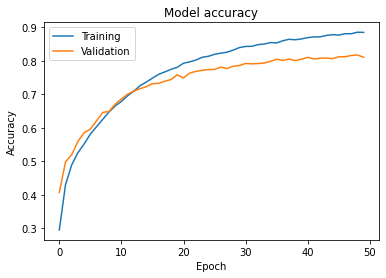

In [ ]:
plt.plot(cnn.history['accuracy'])
plt.plot(cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

### Music recommendation

In [ ]:
test_images = pd.read_csv("/content/drive/MyDrive/Emotion Recognition/test.csv")
test_images.head(5)

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [ ]:
music_playlist = pd.read_csv("/content/drive/MyDrive/Emotion Recognition/data_moods.csv")
music_playlist = music_playlist[['name', 'album', 'artist', 'popularity', 'mood']]
music_playlist.head(5)

,name,album,artist,popularity,mood
0,1999,1999,Prince,68,Happy
1,23,23,Blonde Redhead,43,Sad
2,9 Crimes,9,Damien Rice,60,Sad
3,99 Luftballons,99 Luftballons,Nena,2,Happy
4,A Boy Brushed Red Living In Black And White,They're Only Chasing Safety,Underoath,60,Energetic


In [ ]:
music_playlist['mood'].value_counts()

Sad          197
Calm         195
Energetic    154
Happy        140
Name: mood, dtype: int64

In [ ]:
def select_music(selected_mood):
  selected_songs = music_playlist[music_playlist['mood'] == selected_mood]
  selected_songs = selected_songs[['name', 'album', 'artist']]
  number_of_songs = len(selected_songs)
  num = random.randint(5, number_of_songs)
  #selected_songs.sort_values(by='popularity', ascending=True)
  selected_songs = selected_songs[num-5:num]
  selected_songs = selected_songs.reset_index(drop=True)
  return selected_songs

In [ ]:
def select_music_mood(predicted_emotion):
  music_mood = ""
  if (predicted_emotion=='disgust'):
    music_mood ='Sad'      
  elif (predicted_emotion=='happy' or predicted_emotion=='sad' ):
    music_mood = 'Happy'      
  elif (predicted_emotion=='fear' or predicted_emotion=='angry' ):
    music_mood = 'Calm'
  elif (predicted_emotion=='surprise' or predicted_emotion=='neutral' ):
    music_mood = 'Energetic'
  else:
    print("Unknown predicted emotion!")
  
  return music_mood       

In [ ]:
prediction_images = [0, 68, 100, 150, 250, 351, 406, 500]
num = random.randint(0, 7)
image_to_test = prediction_images[num]

1/1 [==============================] - 0s 17ms/step
         name       album               artist
0  Light Year  Light Year   Evan Michael Brown
1   Limitless   Limitless         Lucas Delphy
2      Litost      Litost                Minxz
3   Los Feliz   Los Feliz  Search For Atlantis
4        Lost        Lost              Annelie


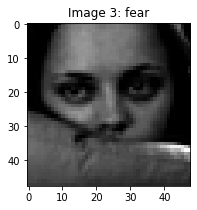

In [ ]:
image_pixels = test_images.iloc[image_to_test, -1]
image_data = np.fromstring(image_pixels, dtype=int, sep=' ').reshape(48, 48, 1)
image_data = image_data/255
x = np.expand_dims(image_data, axis=0)
emotion_num = model_cnn.predict(x)
class_integer = np.argmax(emotion_num, axis=1)
emotion = emotion_dict[class_integer[0]]
 
fig = plt.figure(figsize=(3,3))
a = fig.add_subplot(1, 1, 1)
a.imshow(image_data.reshape(48, 48), cmap="binary_r")
a.set_title("Image " + str(num) + ": " + emotion)
music_mood = select_music_mood(emotion)
selected_songs = select_music(music_mood)
print(selected_songs.head().to_string())